In [1]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import matplotlib.animation as anm
import matplotlib.patches as patches
import math
import numpy as np
import time

In [45]:
class World:
    def __init__(self,time_span,time_interval,debug=False):
        self.time_span=time_span
        self.time_interval=time_interval
        self.debug=debug
        self.objects=[]
    
    def append(self,obj):
        print("[debug] World: append")
        self.objects.append(obj)
    
    def draw(self):
        print("[debug] World: draw")
        fig=plt.figure(figsize=(3,3))
        ax=fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.set_xlim(-5,5)
        ax.set_ylim(-5,5)
        ax.set_xlabel("X",fontsize=10)
        ax.set_ylabel("Y",fontsize=10)
        
        elems=[]
        
        if self.debug:
            for frame in range(1000):
                self.one_step(frame,ax,elems)
                time.sleep(1)
        else:
            self.ani=anm.FuncAnimation(fig=fig,func=self.one_step,frames=int(self.time_span/self.time_interval),fargs=(ax,elems),interval=int(self.time_interval*1000),repeat=False)
            self.ani.save("proto_type_no3.gif", writer = 'Pillow')
            plt.show()
    
    def one_step(self,time,ax,elems):
        print("[debug] World: one_step")
        while elems: elems.pop().remove()
        second="time= %.2f[s]"%(time*self.time_interval)
        elems.append(ax.text(-4.5,4.5,str(second),fontsize=10))
        for obj in self.objects:
            obj.draw(ax,elems)
            if hasattr(obj,"one_step"):obj.one_step(self.time_interval)

In [46]:
class IdealRobot:
    def __init__(self,pose,color="black",agent=None,sensor=None):
        self.pose=pose
        self.r=0.5
        self.color=color
        self.agent=agent
        self.sensor=sensor
        self.poses=[pose]
        self.diff=[]
    
    def draw(self,ax,elems):
        print("[debug] IdealRobot: draw")
        x,y,theta=self.pose
        self.poses.append(self.pose)
        xn=x+self.r*math.cos(theta)
        yn=y+self.r*math.sin(theta)
        elems+=ax.plot([x,xn],[y,yn],color=self.color)
        c=patches.Circle(xy=(x,y),radius=self.r,color="black",fill=False)
        elems.append(ax.add_patch(c))
        self.diff=self.sensor.measurement(self.pose)
        for i in range(len(self.diff)):
            self.sensor.draw(self.pose,ax,elems,self.diff[i])
    
    @classmethod
    def state_transition(cls,nu,omega,time,pose):
        print("[debug] IdealRobot: state_transition")
        t0=pose[2]
        if math.fabs(omega)<1e-10:
            return pose+np.array([nu*math.cos(t0),
                                   nu*math.sin(t0),
                                   omega
                                   ])*time
        else:
            return pose+np.array([nu/omega*(math.sin(t0+omega*time)-math.sin(t0)),
                                   nu/omega*(-math.cos(t0+omega*time)+math.cos(t0)),
                                   omega*time])
        
    def one_step(self,time):
        print("[debug] IdealRobot: one_step")
        nu,omega=self.agent.decision(self.diff)
        self.pose=self.state_transition(nu,omega,time,self.pose)

In [47]:
class Agent:
    def __init__(self,nu,omega):
        self.nu=nu
        self.omega=omega
    
    def decision(self,obs=None):
        print("[debug] Agent: decision")
        for i in range(len(obs)):
            sum_distance=0
            sum_dirct=0
            j=1
            if obs[i][0]>0:
                sum_distance=sum_distance+obs[i][0]
                sum_dirct=   sum_dirct   +obs[i][1]
                j=j+1
        ave_distance=sum_distance/j
        ave_dirct   =sum_dirct/j
        if (ave_dirct>=0):
            if (ave_distance>3):
                self.omega=0
            elif ave_distance>2 and ave_distance<=3:
                self.omega=self.omega-math.radians(3)
            elif ave_distance>1 and ave_distance<=2:
                self.omega=self.omega-math.radians(6)
            elif ave_distance>0.5 and ave_distance<=1:
                self.omega=self.omega-math.radians(30)
            elif ave_distance>0 and ave_distance<=0.5:
                self.omega=self.omega-math.radians(360)
            else:
                self.omega=0
            
        else:
            if (ave_distance>3):
                self.omega=0
            elif ave_distance>2 and ave_distance<=3:
                self.omega=self.omega+math.radians(3)
            elif ave_distance>1 and ave_distance<=2:
                self.omega=self.omega+math.radians(6)
            elif ave_distance>0.5 and ave_distance<=1:
                self.omega=self.omega+math.radians(30)
            elif ave_distance>0 and ave_distance<=0.5:
                self.omega=self.omega+math.radians(360)
            else:
                self.omega=0
            
        return self.nu,self.omega

In [48]:
class Map:
    def __init__(self):
        self.landmarks= []
    
    def append_landmark(self,lm):
        print("[debug] Map: append_landmark")
        lm.id=len(self.landmarks)
        self.landmarks.append(lm)
    
    def draw(self,ax,elems):
        print("[debug] Map: draw")
        for lm in self.landmarks:
            lm.draw(ax,elems)

In [49]:
class Landmark:
    def __init__(self,pos,id=None):
        self.pos=pos
        self.id=id
        
    def draw(self,ax,elems):
        elems.append(ax.scatter(self.pos[0],self.pos[1],s=100,marker="|",color="orange"))
        #elems.append(ax.text(self.pos[0],self.pos[1],"id:"+str(self.id),fontsize=10))

In [50]:
class IdealCamera:
    def __init__(self):
        self.map=None
    
    def capture(self,m):
        self.map=m
    
    def measurement(self,pose):
        result=[]
        for lm in self.map.landmarks:
            xd=lm.pos[0]-pose[0]
            yd=lm.pos[1]-pose[1]
            distance=math.sqrt(xd**2+yd**2)
            dd=math.atan2(yd,xd)-pose[2]
            #print("------------------------")
            #print("------------------------")
            #print("fai:%.1f, theta:%.1f"%(math.degrees(dd),math.degrees(pose[2])))
            #print("distance:%.2f,  dd:%.1f"%(distance,math.degrees(dd)))
            while dd >= np.pi: dd -= 2*np.pi
            while dd < -np.pi: dd += 2*np.pi
            if (distance <=3):
                distance=distance
            else:
                distance=0
            #print("------------------------")
            #print("distance:%.2f,  dd:%.1f"%(distance,math.degrees(dd)))
            set_rslt=(distance,dd)
            result.append(set_rslt)
        return result
    
    def draw(self,pose,ax,elems,diff):
        #print("[debug]:Idealcamera ",pose,diff[0],diff[1])
        x,y,theta=pose
        xn=x+diff[0]*math.cos(diff[1]+theta)
        yn=y+diff[0]*math.sin(diff[1]+theta)
        elems+=ax.plot([x,xn],[y,yn],color="pink",alpha=0.5)
        print("[x,y],[xn,yn]",x,y,xn,yn)

MovieWriter Pillow unavailable; using Pillow instead.


[debug] Map: append_landmark
[debug] Map: append_landmark
[debug] Map: append_landmark
[debug] Map: append_landmark
[debug] Map: append_landmark
[debug] Map: append_landmark
[debug] Map: append_landmark
[debug] Map: append_landmark
[debug] Map: append_landmark
[debug] Map: append_landmark
[debug] Map: append_landmark
[debug] Map: append_landmark
[debug] Map: append_landmark
[debug] World: append
[debug] World: append
[debug] World: draw
[debug] World: one_step
[debug] Map: draw
[debug] IdealRobot: draw
[x,y],[xn,yn] 1.0 0.0 1.0 0.0
[x,y],[xn,yn] 1.0 0.0 1.0 0.0
[x,y],[xn,yn] 1.0 0.0 1.0 0.0
[x,y],[xn,yn] 1.0 0.0 1.0 0.0
[x,y],[xn,yn] 1.0 0.0 1.0 0.0
[x,y],[xn,yn] 1.0 0.0 1.0 0.0
[x,y],[xn,yn] 1.0 0.0 1.0 0.0
[x,y],[xn,yn] 1.0 0.0 1.0 0.0
[x,y],[xn,yn] 1.0 0.0 1.0 0.0
[x,y],[xn,yn] 1.0 0.0 1.0 0.0
[x,y],[xn,yn] 1.0 0.0 1.0 0.0
[x,y],[xn,yn] 1.0 0.0 1.0 0.0
[x,y],[xn,yn] 1.0 0.0 1.0 0.0
[debug] IdealRobot: one_step
[debug] Agent: decision
[debug] IdealRobot: state_transition
[debug] Worl

[debug] World: one_step
[debug] Map: draw
[debug] IdealRobot: draw
[x,y],[xn,yn] 0.20000000000000015 9.797174393178825e-17 0.20000000000000015 9.797174393178825e-17
[x,y],[xn,yn] 0.20000000000000015 9.797174393178825e-17 0.20000000000000015 9.797174393178825e-17
[x,y],[xn,yn] 0.20000000000000015 9.797174393178825e-17 0.20000000000000015 9.797174393178825e-17
[x,y],[xn,yn] 0.20000000000000015 9.797174393178825e-17 0.20000000000000015 9.797174393178825e-17
[x,y],[xn,yn] 0.20000000000000015 9.797174393178825e-17 0.20000000000000015 9.797174393178825e-17
[x,y],[xn,yn] 0.20000000000000015 9.797174393178825e-17 0.20000000000000015 9.797174393178825e-17
[x,y],[xn,yn] 0.20000000000000015 9.797174393178825e-17 0.20000000000000015 9.797174393178825e-17
[x,y],[xn,yn] 0.20000000000000015 9.797174393178825e-17 0.20000000000000015 9.797174393178825e-17
[x,y],[xn,yn] 0.20000000000000015 9.797174393178825e-17 0.20000000000000015 9.797174393178825e-17
[x,y],[xn,yn] 0.20000000000000015 9.797174393178825

[debug] World: one_step
[debug] Map: draw
[debug] IdealRobot: draw
[x,y],[xn,yn] -0.6999999999999998 2.0818995585505003e-16 -0.6999999999999998 2.0818995585505003e-16
[x,y],[xn,yn] -0.6999999999999998 2.0818995585505003e-16 -0.6999999999999998 2.0818995585505003e-16
[x,y],[xn,yn] -0.6999999999999998 2.0818995585505003e-16 -0.6999999999999998 2.0818995585505003e-16
[x,y],[xn,yn] -0.6999999999999998 2.0818995585505003e-16 -0.6999999999999998 2.0818995585505003e-16
[x,y],[xn,yn] -0.6999999999999998 2.0818995585505003e-16 -0.6999999999999998 2.0818995585505003e-16
[x,y],[xn,yn] -0.6999999999999998 2.0818995585505003e-16 -0.6999999999999998 2.0818995585505003e-16
[x,y],[xn,yn] -0.6999999999999998 2.0818995585505003e-16 -0.6999999999999998 2.0818995585505003e-16
[x,y],[xn,yn] -0.6999999999999998 2.0818995585505003e-16 -0.6999999999999998 2.0818995585505003e-16
[x,y],[xn,yn] -0.6999999999999998 2.0818995585505003e-16 -0.6999999999999998 2.0818995585505003e-16
[x,y],[xn,yn] -0.6999999999999998

[debug] World: one_step
[debug] Map: draw
[debug] IdealRobot: draw
[x,y],[xn,yn] -1.5998592931362445 -0.007328249058526566 -3.9999999999999996 -1.2499999999999998
[x,y],[xn,yn] -1.5998592931362445 -0.007328249058526566 -4.000000000000001 -1.049999999999998
[x,y],[xn,yn] -1.5998592931362445 -0.007328249058526566 -4.0 -0.8500000000000001
[x,y],[xn,yn] -1.5998592931362445 -0.007328249058526566 -4.0 -0.6499999999999991
[x,y],[xn,yn] -1.5998592931362445 -0.007328249058526566 -4.0 -0.449999999999999
[x,y],[xn,yn] -1.5998592931362445 -0.007328249058526566 -4.0 -0.24999999999999895
[x,y],[xn,yn] -1.5998592931362445 -0.007328249058526566 -4.0 -0.049999999999999864
[x,y],[xn,yn] -1.5998592931362445 -0.007328249058526566 -4.0 0.14999999999999966
[x,y],[xn,yn] -1.5998592931362445 -0.007328249058526566 -4.0 0.3500000000000004
[x,y],[xn,yn] -1.5998592931362445 -0.007328249058526566 -4.0 0.5500000000000003
[x,y],[xn,yn] -1.5998592931362445 -0.007328249058526566 -4.0 0.7499999999999999
[x,y],[xn,yn] -

[debug] World: one_step
[debug] Map: draw
[debug] IdealRobot: draw
[x,y],[xn,yn] -2.4190289257160558 -0.3244203949010326 -4.0 -1.2500000000000002
[x,y],[xn,yn] -2.4190289257160558 -0.3244203949010326 -4.0 -1.049999999999999
[x,y],[xn,yn] -2.4190289257160558 -0.3244203949010326 -4.0 -0.85
[x,y],[xn,yn] -2.4190289257160558 -0.3244203949010326 -4.0 -0.6499999999999988
[x,y],[xn,yn] -2.4190289257160558 -0.3244203949010326 -4.0 -0.4499999999999993
[x,y],[xn,yn] -2.4190289257160558 -0.3244203949010326 -4.0 -0.25
[x,y],[xn,yn] -2.4190289257160558 -0.3244203949010326 -4.0 -0.04999999999999993
[x,y],[xn,yn] -2.4190289257160558 -0.3244203949010326 -4.0 0.1499999999999999
[x,y],[xn,yn] -2.4190289257160558 -0.3244203949010326 -4.0 0.34999999999999987
[x,y],[xn,yn] -2.4190289257160558 -0.3244203949010326 -4.0 0.5500000000000004
[x,y],[xn,yn] -2.4190289257160558 -0.3244203949010326 -4.0 0.7500000000000001
[x,y],[xn,yn] -2.4190289257160558 -0.3244203949010326 -4.0 0.9500000000000003
[x,y],[xn,yn] -2.

[debug] World: one_step
[debug] Map: draw
[debug] IdealRobot: draw
[x,y],[xn,yn] -2.440676357092222 -1.131279704639794 -4.0 -1.25
[x,y],[xn,yn] -2.440676357092222 -1.131279704639794 -4.0 -1.0499999999999998
[x,y],[xn,yn] -2.440676357092222 -1.131279704639794 -4.0 -0.8499999999999999
[x,y],[xn,yn] -2.440676357092222 -1.131279704639794 -4.0 -0.65
[x,y],[xn,yn] -2.440676357092222 -1.131279704639794 -4.0 -0.44999999999999996
[x,y],[xn,yn] -2.440676357092222 -1.131279704639794 -4.0 -0.2499999999999999
[x,y],[xn,yn] -2.440676357092222 -1.131279704639794 -4.0 -0.04999999999999982
[x,y],[xn,yn] -2.440676357092222 -1.131279704639794 -4.0 0.1499999999999999
[x,y],[xn,yn] -2.440676357092222 -1.131279704639794 -4.0 0.3500000000000003
[x,y],[xn,yn] -2.440676357092222 -1.131279704639794 -4.0 0.5499999999999994
[x,y],[xn,yn] -2.440676357092222 -1.131279704639794 -4.000000000000001 0.7499999999999993
[x,y],[xn,yn] -2.440676357092222 -1.131279704639794 -4.0 0.9499999999999995
[x,y],[xn,yn] -2.440676357

[debug] World: one_step
[debug] Map: draw
[debug] IdealRobot: draw
[x,y],[xn,yn] -1.5894134512001734 -1.39013913571113 -4.0 -1.2500000000000004
[x,y],[xn,yn] -1.5894134512001734 -1.39013913571113 -4.0 -1.0499999999999996
[x,y],[xn,yn] -1.5894134512001734 -1.39013913571113 -3.999999999999999 -0.8499999999999975
[x,y],[xn,yn] -1.5894134512001734 -1.39013913571113 -3.999999999999999 -0.6499999999999986
[x,y],[xn,yn] -1.5894134512001734 -1.39013913571113 -3.999999999999999 -0.44999999999999907
[x,y],[xn,yn] -1.5894134512001734 -1.39013913571113 -3.999999999999999 -0.24999999999999845
[x,y],[xn,yn] -1.5894134512001734 -1.39013913571113 -3.999999999999999 -0.04999999999999938
[x,y],[xn,yn] -1.5894134512001734 -1.39013913571113 -4.0 0.14999999999999925
[x,y],[xn,yn] -1.5894134512001734 -1.39013913571113 -4.000000000000001 0.34999999999999853
[x,y],[xn,yn] -1.5894134512001734 -1.39013913571113 -1.5894134512001734 -1.39013913571113
[x,y],[xn,yn] -1.5894134512001734 -1.39013913571113 -1.58941345

[x,y],[xn,yn] -0.8068953706131292 -1.5564684883653372 -0.8068953706131292 -1.5564684883653372
[x,y],[xn,yn] -0.8068953706131292 -1.5564684883653372 -0.8068953706131292 -1.5564684883653372
[x,y],[xn,yn] -0.8068953706131292 -1.5564684883653372 -0.8068953706131292 -1.5564684883653372
[x,y],[xn,yn] -0.8068953706131292 -1.5564684883653372 -0.8068953706131292 -1.5564684883653372
[x,y],[xn,yn] -0.8068953706131292 -1.5564684883653372 -0.8068953706131292 -1.5564684883653372
[x,y],[xn,yn] -0.8068953706131292 -1.5564684883653372 -0.8068953706131292 -1.5564684883653372
[x,y],[xn,yn] -0.8068953706131292 -1.5564684883653372 -0.8068953706131292 -1.5564684883653372
[x,y],[xn,yn] -0.8068953706131292 -1.5564684883653372 -0.8068953706131292 -1.5564684883653372
[x,y],[xn,yn] -0.8068953706131292 -1.5564684883653372 -0.8068953706131292 -1.5564684883653372
[x,y],[xn,yn] -0.8068953706131292 -1.5564684883653372 -0.8068953706131292 -1.5564684883653372
[x,y],[xn,yn] -0.8068953706131292 -1.5564684883653372 -0.806

[x,y],[xn,yn] 0.0734374700472958 -1.7435890101013205 0.0734374700472958 -1.7435890101013205
[x,y],[xn,yn] 0.0734374700472958 -1.7435890101013205 0.0734374700472958 -1.7435890101013205
[x,y],[xn,yn] 0.0734374700472958 -1.7435890101013205 0.0734374700472958 -1.7435890101013205
[x,y],[xn,yn] 0.0734374700472958 -1.7435890101013205 0.0734374700472958 -1.7435890101013205
[x,y],[xn,yn] 0.0734374700472958 -1.7435890101013205 0.0734374700472958 -1.7435890101013205
[debug] IdealRobot: one_step
[debug] Agent: decision
[debug] IdealRobot: state_transition
[debug] World: one_step
[debug] Map: draw
[debug] IdealRobot: draw
[x,y],[xn,yn] 0.17125223012067636 -1.7643801791830964 0.17125223012067636 -1.7643801791830964
[x,y],[xn,yn] 0.17125223012067636 -1.7643801791830964 0.17125223012067636 -1.7643801791830964
[x,y],[xn,yn] 0.17125223012067636 -1.7643801791830964 0.17125223012067636 -1.7643801791830964
[x,y],[xn,yn] 0.17125223012067636 -1.7643801791830964 0.17125223012067636 -1.7643801791830964
[x,y],[

[debug] IdealRobot: draw
[x,y],[xn,yn] 0.9537703107077208 -1.9307095318373038 0.9537703107077208 -1.9307095318373038
[x,y],[xn,yn] 0.9537703107077208 -1.9307095318373038 0.9537703107077208 -1.9307095318373038
[x,y],[xn,yn] 0.9537703107077208 -1.9307095318373038 0.9537703107077208 -1.9307095318373038
[x,y],[xn,yn] 0.9537703107077208 -1.9307095318373038 0.9537703107077208 -1.9307095318373038
[x,y],[xn,yn] 0.9537703107077208 -1.9307095318373038 0.9537703107077208 -1.9307095318373038
[x,y],[xn,yn] 0.9537703107077208 -1.9307095318373038 0.9537703107077208 -1.9307095318373038
[x,y],[xn,yn] 0.9537703107077208 -1.9307095318373038 0.9537703107077208 -1.9307095318373038
[x,y],[xn,yn] 0.9537703107077208 -1.9307095318373038 0.9537703107077208 -1.9307095318373038
[x,y],[xn,yn] 0.9537703107077208 -1.9307095318373038 0.9537703107077208 -1.9307095318373038
[x,y],[xn,yn] 0.9537703107077208 -1.9307095318373038 0.9537703107077208 -1.9307095318373038
[x,y],[xn,yn] 0.9537703107077208 -1.9307095318373038 0.

[debug] IdealRobot: draw
[x,y],[xn,yn] 1.8341031513681456 -2.117830053573288 1.8341031513681456 -2.117830053573288
[x,y],[xn,yn] 1.8341031513681456 -2.117830053573288 1.8341031513681456 -2.117830053573288
[x,y],[xn,yn] 1.8341031513681456 -2.117830053573288 1.8341031513681456 -2.117830053573288
[x,y],[xn,yn] 1.8341031513681456 -2.117830053573288 1.8341031513681456 -2.117830053573288
[x,y],[xn,yn] 1.8341031513681456 -2.117830053573288 1.8341031513681456 -2.117830053573288
[x,y],[xn,yn] 1.8341031513681456 -2.117830053573288 1.8341031513681456 -2.117830053573288
[x,y],[xn,yn] 1.8341031513681456 -2.117830053573288 1.8341031513681456 -2.117830053573288
[x,y],[xn,yn] 1.8341031513681456 -2.117830053573288 1.8341031513681456 -2.117830053573288
[x,y],[xn,yn] 1.8341031513681456 -2.117830053573288 1.8341031513681456 -2.117830053573288
[x,y],[xn,yn] 1.8341031513681456 -2.117830053573288 1.8341031513681456 -2.117830053573288
[x,y],[xn,yn] 1.8341031513681456 -2.117830053573288 1.8341031513681456 -2.1

[debug] IdealRobot: draw
[x,y],[xn,yn] 2.714435992028572 -2.3049505753092734 2.714435992028572 -2.3049505753092734
[x,y],[xn,yn] 2.714435992028572 -2.3049505753092734 2.714435992028572 -2.3049505753092734
[x,y],[xn,yn] 2.714435992028572 -2.3049505753092734 2.714435992028572 -2.3049505753092734
[x,y],[xn,yn] 2.714435992028572 -2.3049505753092734 2.714435992028572 -2.3049505753092734
[x,y],[xn,yn] 2.714435992028572 -2.3049505753092734 2.714435992028572 -2.3049505753092734
[x,y],[xn,yn] 2.714435992028572 -2.3049505753092734 2.714435992028572 -2.3049505753092734
[x,y],[xn,yn] 2.714435992028572 -2.3049505753092734 2.714435992028572 -2.3049505753092734
[x,y],[xn,yn] 2.714435992028572 -2.3049505753092734 2.714435992028572 -2.3049505753092734
[x,y],[xn,yn] 2.714435992028572 -2.3049505753092734 2.714435992028572 -2.3049505753092734
[x,y],[xn,yn] 2.714435992028572 -2.3049505753092734 2.714435992028572 -2.3049505753092734
[x,y],[xn,yn] 2.714435992028572 -2.3049505753092734 2.714435992028572 -2.30

[debug] IdealRobot: draw
[x,y],[xn,yn] 3.594768832688999 -2.4920710970452586 3.594768832688999 -2.4920710970452586
[x,y],[xn,yn] 3.594768832688999 -2.4920710970452586 3.594768832688999 -2.4920710970452586
[x,y],[xn,yn] 3.594768832688999 -2.4920710970452586 3.594768832688999 -2.4920710970452586
[x,y],[xn,yn] 3.594768832688999 -2.4920710970452586 3.594768832688999 -2.4920710970452586
[x,y],[xn,yn] 3.594768832688999 -2.4920710970452586 3.594768832688999 -2.4920710970452586
[x,y],[xn,yn] 3.594768832688999 -2.4920710970452586 3.594768832688999 -2.4920710970452586
[x,y],[xn,yn] 3.594768832688999 -2.4920710970452586 3.594768832688999 -2.4920710970452586
[x,y],[xn,yn] 3.594768832688999 -2.4920710970452586 3.594768832688999 -2.4920710970452586
[x,y],[xn,yn] 3.594768832688999 -2.4920710970452586 3.594768832688999 -2.4920710970452586
[x,y],[xn,yn] 3.594768832688999 -2.4920710970452586 3.594768832688999 -2.4920710970452586
[x,y],[xn,yn] 3.594768832688999 -2.4920710970452586 3.594768832688999 -2.49

[x,y],[xn,yn] 4.4751016733494255 -2.679191618781244 4.4751016733494255 -2.679191618781244
[x,y],[xn,yn] 4.4751016733494255 -2.679191618781244 4.4751016733494255 -2.679191618781244
[x,y],[xn,yn] 4.4751016733494255 -2.679191618781244 4.4751016733494255 -2.679191618781244
[x,y],[xn,yn] 4.4751016733494255 -2.679191618781244 4.4751016733494255 -2.679191618781244
[x,y],[xn,yn] 4.4751016733494255 -2.679191618781244 4.4751016733494255 -2.679191618781244
[x,y],[xn,yn] 4.4751016733494255 -2.679191618781244 4.4751016733494255 -2.679191618781244
[x,y],[xn,yn] 4.4751016733494255 -2.679191618781244 4.4751016733494255 -2.679191618781244
[x,y],[xn,yn] 4.4751016733494255 -2.679191618781244 4.4751016733494255 -2.679191618781244
[x,y],[xn,yn] 4.4751016733494255 -2.679191618781244 4.4751016733494255 -2.679191618781244
[x,y],[xn,yn] 4.4751016733494255 -2.679191618781244 4.4751016733494255 -2.679191618781244
[x,y],[xn,yn] 4.4751016733494255 -2.679191618781244 4.4751016733494255 -2.679191618781244
[x,y],[xn,

[x,y],[xn,yn] 5.355434514009852 -2.866312140517229 5.355434514009852 -2.866312140517229
[x,y],[xn,yn] 5.355434514009852 -2.866312140517229 5.355434514009852 -2.866312140517229
[x,y],[xn,yn] 5.355434514009852 -2.866312140517229 5.355434514009852 -2.866312140517229
[x,y],[xn,yn] 5.355434514009852 -2.866312140517229 5.355434514009852 -2.866312140517229
[x,y],[xn,yn] 5.355434514009852 -2.866312140517229 5.355434514009852 -2.866312140517229
[x,y],[xn,yn] 5.355434514009852 -2.866312140517229 5.355434514009852 -2.866312140517229
[x,y],[xn,yn] 5.355434514009852 -2.866312140517229 5.355434514009852 -2.866312140517229
[x,y],[xn,yn] 5.355434514009852 -2.866312140517229 5.355434514009852 -2.866312140517229
[x,y],[xn,yn] 5.355434514009852 -2.866312140517229 5.355434514009852 -2.866312140517229
[x,y],[xn,yn] 5.355434514009852 -2.866312140517229 5.355434514009852 -2.866312140517229
[x,y],[xn,yn] 5.355434514009852 -2.866312140517229 5.355434514009852 -2.866312140517229
[x,y],[xn,yn] 5.355434514009852 

[debug] Map: draw
[debug] IdealRobot: draw
[x,y],[xn,yn] 6.235767354670279 -3.0534326622532144 6.235767354670279 -3.0534326622532144
[x,y],[xn,yn] 6.235767354670279 -3.0534326622532144 6.235767354670279 -3.0534326622532144
[x,y],[xn,yn] 6.235767354670279 -3.0534326622532144 6.235767354670279 -3.0534326622532144
[x,y],[xn,yn] 6.235767354670279 -3.0534326622532144 6.235767354670279 -3.0534326622532144
[x,y],[xn,yn] 6.235767354670279 -3.0534326622532144 6.235767354670279 -3.0534326622532144
[x,y],[xn,yn] 6.235767354670279 -3.0534326622532144 6.235767354670279 -3.0534326622532144
[x,y],[xn,yn] 6.235767354670279 -3.0534326622532144 6.235767354670279 -3.0534326622532144
[x,y],[xn,yn] 6.235767354670279 -3.0534326622532144 6.235767354670279 -3.0534326622532144
[x,y],[xn,yn] 6.235767354670279 -3.0534326622532144 6.235767354670279 -3.0534326622532144
[x,y],[xn,yn] 6.235767354670279 -3.0534326622532144 6.235767354670279 -3.0534326622532144
[x,y],[xn,yn] 6.235767354670279 -3.0534326622532144 6.235

[debug] World: one_step
[debug] Map: draw
[debug] IdealRobot: draw
[x,y],[xn,yn] 7.116100195330706 -3.2405531839891997 7.116100195330706 -3.2405531839891997
[x,y],[xn,yn] 7.116100195330706 -3.2405531839891997 7.116100195330706 -3.2405531839891997
[x,y],[xn,yn] 7.116100195330706 -3.2405531839891997 7.116100195330706 -3.2405531839891997
[x,y],[xn,yn] 7.116100195330706 -3.2405531839891997 7.116100195330706 -3.2405531839891997
[x,y],[xn,yn] 7.116100195330706 -3.2405531839891997 7.116100195330706 -3.2405531839891997
[x,y],[xn,yn] 7.116100195330706 -3.2405531839891997 7.116100195330706 -3.2405531839891997
[x,y],[xn,yn] 7.116100195330706 -3.2405531839891997 7.116100195330706 -3.2405531839891997
[x,y],[xn,yn] 7.116100195330706 -3.2405531839891997 7.116100195330706 -3.2405531839891997
[x,y],[xn,yn] 7.116100195330706 -3.2405531839891997 7.116100195330706 -3.2405531839891997
[x,y],[xn,yn] 7.116100195330706 -3.2405531839891997 7.116100195330706 -3.2405531839891997
[x,y],[xn,yn] 7.116100195330706 -

<IPython.core.display.Javascript object>


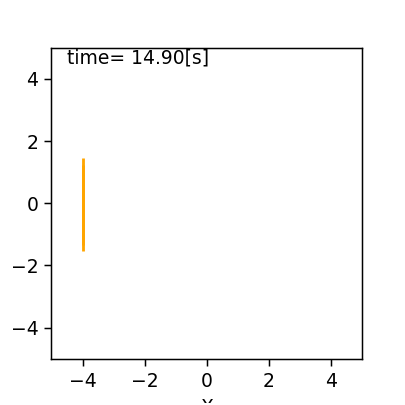

In [51]:
world=World(15,0.1,debug=False)

m=Map()
v=25
for i in range(0,v,2): m.append_landmark(Landmark(np.array([-4,i*0.1-(v*0.1/2)])))
world.append(m)
straight=Agent(1,0)
cm1=IdealCamera()
cm1.capture(m)
robot1=IdealRobot(np.array([1,0,math.pi]).T,agent=straight,sensor=cm1)
world.append(robot1)

world.draw()